In [1]:
from sisyphus.utils.helper_functions import get_create_resultdb

FileNotFoundError: [Errno 2] No such file or directory: 'config/throttle_config.json'

In [ ]:
result_db = get_create_resultdb('heas_test_traditional')
results = result_db.load_as_json('4o/4o-mini', '', '', with_doi=True)
results[:5]

e:\anaconda\envs\sisyphus_heas\lib\site-packages\pydantic\main.py:1552: RuntimeWarning: fields may not start with an underscore, ignoring "__tablename__"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


[{'model_name': '4o/4o-mini', 'instruction': '', 'db_name': ''},
 {'composition': 'VCoNi',
  'composition_type': 'atomic',
  'phase': ['fcc'],
  'ys': 1000.0,
  'uts': 1359.0,
  'strain': 38.0,
  'processes': ['induction melting: atmosphere: Ar',
   'homogenized: temperature: 1200 °C, duration: 24 h',
   'cold rolled: reduction: 75%',
   'annealed: temperature: 900 °C, duration: 60 min',
   'quenching: medium: water'],
  'test_type': 'tensile',
  'test_temperature': '25 °C',
  'doi': '10.1002/adma.201807142'},
 {'composition': 'CrCoNi',
  'composition_type': 'atomic',
  'phase': ['fcc'],
  'ys': 460.0,
  'uts': None,
  'strain': None,
  'processes': None,
  'test_type': 'tensile',
  'test_temperature': '25 °C',
  'doi': '10.1002/adma.201807142'},
 {'composition': 'CoCuFeMnNi',
  'composition_type': 'atomic',
  'phase': ['FCC'],
  'ys': 259.4,
  'uts': 580.3,
  'strain': 28.3,
  'processes': ['arc melting: atmosphere: Ar, remelting times: 6',
   'cold rolled: reduction: 90%, temperature

In [2]:
import json
with open('heas_result.json', 'r', encoding='utf8') as f:
    results = json.load(f)

In [3]:
results.pop(0)

{'model_name': '4o',
 'instruction': 'ommit',
 'db_name': 'heas_test_traditional'}

#### Composition, phase formatting

In [4]:
# since below code are designed for atomoic composition, omit the weight composition first.
import re
from pymatgen.core.composition import Composition

def has_parentheses(text):
    return re.search(r'\(.*\)', text) is not None

def extract_outer_parentheses(text):
    unclosed_parenth = 0
    for i, c in enumerate(text):
        if c == '(':
            if unclosed_parenth == 0:
                start = i
            unclosed_parenth += 1
        elif c == ')':
            unclosed_parenth -= 1
            if unclosed_parenth == 0:
                yield text[start:i+1]

def normalize(formula):
    for match in extract_outer_parentheses(formula):
        without_parentheses = match[1:-1]
        multiplier = get_multiplier(match, formula)
        if has_parentheses(without_parentheses):
            without_parentheses = normalize(without_parentheses)
        formatted = formatted_p(without_parentheses, multiplier)
        to_replace = re.compile(re.escape(match) + r'(\d+\.\d+|\d*)')
        formula = re.sub(to_replace, formatted, formula)

    return formula

def get_multiplier(match, formula):
    pattern = re.compile(re.escape(match) + r'(\d+(\.\d+)?)')
    match = pattern.search(formula)
    return float(match.group(1)) if match else 1

def formatted_p(formula, multiplier):
    """formatted composition with multiplier.

    Example:
        formatted_p('CoCrNi', 94) -> Co31.33333333 Cr31.33333333 Ni31.33333333"""
    composition = Composition(formula)
    total = composition.num_atoms
    formatted_comp = Composition({el: num/total*multiplier for el, num in composition.items()})
    return str(formatted_comp)

def norm_2_one(formula):
    comp = Composition(formula)
    total = sum(comp.values())
    return str(Composition({el: round(num/total, 3) for el, num in comp.items()}).alphabetical_formula)

def parse_material(material):
    # parse material to a normalized format (atomic composition)
    split = material.split('-')
    if len(split) != 2: # not doped case
        formula = ''.join(split)
        try:
            c = Composition(formula, strict=True) 
            if c:
                if len(c.elements) < 3:
                    return None
            comp = norm_2_one(normalize(formula))
            if comp:
                return comp
        except:
            return None
    return None

fcc = re.compile(r'a1|fcc|f\.c\.c|face(\s|-)?centered(\s|-)?cubic|𝛾(?!\')|austenitic', re.IGNORECASE)
bcc = re.compile(r'a2|bcc|b\.c\.c|body(\s|-)?centered(\s|-)?cubic|𝛽', re.IGNORECASE)
hcp = re.compile(r'hcp|h\.c\.p|hexagonal(\s|-)?close(\s|-)?packed', re.IGNORECASE)
laves = re.compile(r'laves', re.IGNORECASE)
b2 = re.compile(r'b2', re.IGNORECASE)
l12 = re.compile(r'l12', re.IGNORECASE)
amorphous = re.compile(r'amorphous|am', re.IGNORECASE)
order = re.compile(r'order|ordered', re.IGNORECASE)
im = re.compile(r'im|𝜎|TiC|b2|laves|l12|intermetallic|sigma|𝜇', re.IGNORECASE)
match_dict = {'FCC': fcc, 'BCC': bcc, 'HCP': hcp, 'Laves': laves, 'B2': b2, 'L12': l12, 'AM': amorphous, 'IM': im}

def formatted_phase(phase):
    for p in match_dict:
        if match_dict[p].search(phase):
            if p == 'FCC':
                if order.search(phase) or match_dict['L12'].search(phase):
                    return 'L12'
            if p == 'BCC':
                if order.search(phase) or match_dict['B2'].search(phase):
                    return 'B2'
            return p
    return phase 

def clean_phase(row):
    if not row.phase:
        return None
    return [formatted_phase(p) for p in row.phase]

def formatted_temp(row):
    value_p = re.compile(r'\d+(\.\d+)?')
    unit_p = re.compile(r'[^\d.]+')
    temp = row.test_temperature
    try:
        tp, unit = value_p.search(temp).group(0), unit_p.search(temp).group(0).strip()
    except:
        return None
    if unit == 'K':
        tp = float(tp)
        tp = tp - 273
    return int(float(tp))


In [6]:
import pandas as pd

df = pd.DataFrame(results)
df['composition_cleaned'] = df.composition.apply(parse_material)
df['test_temperature_cleaned'] = df.apply(formatted_temp, axis=1)
df['phase_cleaned'] = df.apply(clean_phase, axis=1)

In [7]:
"""Task: Classify phases of high entropy alloys (HEAs) into three categories:

Solid Solution – A single-phase structure (e.g., FCC, BCC, HCP, NaCl-type solid solution).

Intermetallic – A well-defined ordered compound with distinct stoichiometry (e.g., TiNi, γ' precipitates, M₅Si₃).

Unrecognized – Phases that do not clearly fit into solid solution or intermetallic categories (e.g., amorphous, oxides, carbides like WC).

Instructions:
Given a list of HEA phases, classify each phase into one of the three categories. Follow these classification rules:

FCC, BCC, HCP, and NaCl-type solid solution → Solid Solution

Intermetallic compounds (e.g., TiNi, Ti₂Ni, γ' precipitates, M₅Si₃, silicides, aluminides, and sigma (σ) phases) → Intermetallic

Carbides (e.g., WC), oxides (e.g., SiO₂), amorphous phases, and unknown structures → Unrecognized"""

"Task: Classify phases of high entropy alloys (HEAs) into three categories:\n\nSolid Solution – A single-phase structure (e.g., FCC, BCC, HCP, NaCl-type solid solution).\n\nIntermetallic – A well-defined ordered compound with distinct stoichiometry (e.g., TiNi, γ' precipitates, M₅Si₃).\n\nUnrecognized – Phases that do not clearly fit into solid solution or intermetallic categories (e.g., amorphous, oxides, carbides like WC).\n\nInstructions:\nGiven a list of HEA phases, classify each phase into one of the three categories. Follow these classification rules:\n\nFCC, BCC, HCP, and NaCl-type solid solution → Solid Solution\n\nIntermetallic compounds (e.g., TiNi, Ti₂Ni, γ' precipitates, M₅Si₃, silicides, aluminides, and sigma (σ) phases) → Intermetallic\n\nCarbides (e.g., WC), oxides (e.g., SiO₂), amorphous phases, and unknown structures → Unrecognized"

In [7]:
# FCC, BCC, HCP, Laves, B2, L12, AM, IM, SS, Other
import dspy
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

lm = dspy.LM('openai/gpt-4o')
dspy.configure(lm=lm)

class Categorize(dspy.Signature):
    """I'll given you some phases extracted from high entropy alloys articles. Categorize the phases to solid solution, intermetallic or other."""
    phases: list[str] = dspy.InputField()
    solid_solution: list[str] = dspy.OutputField()
    intermetallic: list[str] = dspy.OutputField()
    other: list[str] = dspy.OutputField()
categorizer = dspy.ChainOfThought(Categorize)

def formatted_phase_with_lm(phases):
    known = list(match_dict.keys())
    if not phases:
        return []
    recognized = [p for p in phases if p in known]
    unrecognized = [p for p in phases if p not in known]
    if not unrecognized:
        return recognized
    prediction = categorizer(phases=unrecognized)
    ss, im, other = prediction.solid_solution, prediction.intermetallic, prediction.other
    if ss:
        recognized.append('SS')
    if im:
        recognized.append('IM')
    if other:
        recognized.append('Other')
    return recognized

# cleaned = df.phase_cleaned.apply(formatted_phase_with_lm)
ps = df.phase_cleaned.to_list()
ps_formatted = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(formatted_phase_with_lm, p) for p in ps]
    futures_indexed = {f: i for i, f in enumerate(futures)}
    for f in tqdm(as_completed(futures), total=len(futures)):
        ps_formatted.append((futures_indexed[f], f.result()))
    
sort_phase_result = sorted(ps_formatted, key=lambda x: x[0])
sorted_phases = [p[1] for p in sort_phase_result]
df['phase_cleaned_lm'] = sorted_phases

100%|██████████| 5915/5915 [00:01<00:00, 3120.45it/s]


In [8]:
df = df[df.composition_type == 'atomic'] # remove those with weight composition
df

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC]
1,CrCoNi,atomic,[fcc],460.0,NaN,NaN,None,tensile,25 °C,10.1002/adma.201807142,Co0.333 Cr0.333 Ni0.333,25.0,[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]"
4,Co19.90Cr20.00Fe19.90Mn21.30Ni18.90C0.00,atomic,None,NaN,NaN,NaN,"[levitation melting: atmosphere: N2, remelting...",tensile,25 °C,10.1002/mawe.202300263,Co0.199 Cr0.2 Fe0.199 Mn0.213 Ni0.189,25.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,(CuMnNi)80Zn20,atomic,[FCC],140.0,NaN,65.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.267 Mn0.267 Ni0.267 Zn0.2,25.0,[FCC]
5911,(CuMnNi)90Al10,atomic,"[FCC, Im]",515.0,NaN,40.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.1 Cu0.3 Mn0.3 Ni0.3,25.0,"[FCC, IM]"
5912,(CuMnNi)90Sn10,atomic,"[FCC, Im]",630.0,NaN,20.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.3 Mn0.3 Ni0.3 Sn0.1,25.0,"[FCC, IM]"
5913,(CuMnNi)95Al5,atomic,[FCC],330.0,NaN,45.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.05 Cu0.317 Mn0.317 Ni0.317,25.0,[FCC]


In [9]:
df[~df.composition_cleaned.isna()]

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC]
1,CrCoNi,atomic,[fcc],460.0,NaN,NaN,None,tensile,25 °C,10.1002/adma.201807142,Co0.333 Cr0.333 Ni0.333,25.0,[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]"
4,Co19.90Cr20.00Fe19.90Mn21.30Ni18.90C0.00,atomic,None,NaN,NaN,NaN,"[levitation melting: atmosphere: N2, remelting...",tensile,25 °C,10.1002/mawe.202300263,Co0.199 Cr0.2 Fe0.199 Mn0.213 Ni0.189,25.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,(CuMnNi)80Zn20,atomic,[FCC],140.0,NaN,65.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.267 Mn0.267 Ni0.267 Zn0.2,25.0,[FCC]
5911,(CuMnNi)90Al10,atomic,"[FCC, Im]",515.0,NaN,40.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.1 Cu0.3 Mn0.3 Ni0.3,25.0,"[FCC, IM]"
5912,(CuMnNi)90Sn10,atomic,"[FCC, Im]",630.0,NaN,20.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.3 Mn0.3 Ni0.3 Sn0.1,25.0,"[FCC, IM]"
5913,(CuMnNi)95Al5,atomic,[FCC],330.0,NaN,45.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.05 Cu0.317 Mn0.317 Ni0.317,25.0,[FCC]


In [10]:
valid_df = df.dropna(subset=['composition_cleaned', 'ys', 'test_temperature_cleaned'], how='any')
valid_df

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC]
1,CrCoNi,atomic,[fcc],460.0,NaN,NaN,None,tensile,25 °C,10.1002/adma.201807142,Co0.333 Cr0.333 Ni0.333,25.0,[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]"
7,Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04,atomic,"[FCC, γ' precipitates]",1100.0,1700.0,10.0,"[arc melting: atmosphere: Ar, annealed: temper...",tensile,25 °C,10.1016/j.actamat.2020.08.043,Al0.105 Co0.175 Fe0.423 Ni0.275 Ta0.022,25.0,"[FCC, γ' precipitates]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,(CuMnNi)80Zn20,atomic,[FCC],140.0,NaN,65.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.267 Mn0.267 Ni0.267 Zn0.2,25.0,[FCC]
5911,(CuMnNi)90Al10,atomic,"[FCC, Im]",515.0,NaN,40.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.1 Cu0.3 Mn0.3 Ni0.3,25.0,"[FCC, IM]"
5912,(CuMnNi)90Sn10,atomic,"[FCC, Im]",630.0,NaN,20.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.3 Mn0.3 Ni0.3 Sn0.1,25.0,"[FCC, IM]"
5913,(CuMnNi)95Al5,atomic,[FCC],330.0,NaN,45.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.05 Cu0.317 Mn0.317 Ni0.317,25.0,[FCC]


In [11]:
liquid_method = re.compile('(induction|arc|levitation) melting', re.I)
def is_melting_method(p):
    if not p:
        return False
    if len(p) > 1:
        return False
    for process in p:
        if liquid_method.search(process) or re.search('cast', process, re.I):
            return True
    return False

def is_melting_method_loose(p):
    if not p:
        return False
    for process in p:
        if liquid_method.search(process) or re.search('cast', process, re.I):
            return True
    return False

In [12]:
df_tensile_rt = valid_df[(valid_df.test_type == 'tensile') & (valid_df.test_temperature_cleaned.apply(lambda t: int(float(t)) == 25))]
df_tensile_rt

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC]
1,CrCoNi,atomic,[fcc],460.0,NaN,NaN,None,tensile,25 °C,10.1002/adma.201807142,Co0.333 Cr0.333 Ni0.333,25.0,[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]"
7,Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04,atomic,"[FCC, γ' precipitates]",1100.0,1700.0,10.0,"[arc melting: atmosphere: Ar, annealed: temper...",tensile,25 °C,10.1016/j.actamat.2020.08.043,Al0.105 Co0.175 Fe0.423 Ni0.275 Ta0.022,25.0,"[FCC, γ' precipitates]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,FeMnNi,atomic,[FCC],221.0,602.0,36.0,None,tensile,25 °C,10.1016/j.dib.2018.11.111,Fe0.333 Mn0.333 Ni0.333,25.0,[FCC]
5802,CoCrFeNi,atomic,[FCC],274.0,708.0,39.0,None,tensile,25 °C,10.1016/j.dib.2018.11.111,Co0.25 Cr0.25 Fe0.25 Ni0.25,25.0,[FCC]
5803,CoCrMnNi,atomic,[FCC],282.0,694.0,44.0,None,tensile,25 °C,10.1016/j.dib.2018.11.111,Co0.25 Cr0.25 Mn0.25 Ni0.25,25.0,[FCC]
5804,CoFeMnNi,atomic,[FCC],170.0,550.0,41.0,None,tensile,25 °C,10.1016/j.dib.2018.11.111,Co0.25 Fe0.25 Mn0.25 Ni0.25,25.0,[FCC]


In [13]:
df_tensile_rt[df_tensile_rt.processes.apply(is_melting_method)]

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
34,CoCrNi,atomic,None,230.0,620.0,52.0,[casting],tensile,25 °C,10.1016/j.addma.2020.101202,Co0.333 Cr0.333 Ni0.333,25.0,None
269,Al0.1CrFe2Ni2,atomic,[FCC],200.0,500.0,50.0,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.02 Cr0.196 Fe0.392 Ni0.392,25.0,[FCC]
270,Al0.3CrFe2Ni2,atomic,[FCC],200.0,500.0,50.0,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.057 Cr0.189 Fe0.377 Ni0.377,25.0,[FCC]
275,Al0.9CrFe2Ni2,atomic,"[FCC, BCC, B2]",1097.0,1278.0,12.6,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.153 Cr0.169 Fe0.339 Ni0.339,25.0,"[FCC, BCC, B2]"
276,Al1.0CrFe2Ni2,atomic,"[FCC, BCC, B2]",780.0,1031.0,18.9,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.167 Cr0.167 Fe0.333 Ni0.333,25.0,"[FCC, BCC, B2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,CrMo0.5NbTa0.5TiZr,atomic,[Multiphase],1595.0,2046.0,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Cr0.2 Mo0.1 Nb0.2 Ta0.1 Ti0.2 Zr0.2,25.0,[Multiphase]
5732,CrNbTiVZr,atomic,[Multiphase],1298.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Cr0.2 Nb0.2 Ti0.2 V0.2 Zr0.2,25.0,[Multiphase]
5733,CrNbTiZr,atomic,[Multiphase],1260.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Cr0.25 Nb0.25 Ti0.25 Zr0.25,25.0,[Multiphase]
5734,NbTiVZr,atomic,[BCC],1105.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Nb0.25 Ti0.25 V0.25 Zr0.25,25.0,[BCC]


In [14]:
v_df_liquid = valid_df[(valid_df.test_type == 'tensile') & (valid_df.processes.apply(is_melting_method))]
v_df_liquid['test_temperature_cleaned'].value_counts()
def is_rt(t):
    t_int = int(float(t))
    return True if t_int==25 else False
v_df_liquid_rt = v_df_liquid[v_df_liquid['test_temperature_cleaned'].apply(is_rt)]
v_df_liquid_rt

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
34,CoCrNi,atomic,None,230.0,620.0,52.0,[casting],tensile,25 °C,10.1016/j.addma.2020.101202,Co0.333 Cr0.333 Ni0.333,25.0,None
269,Al0.1CrFe2Ni2,atomic,[FCC],200.0,500.0,50.0,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.02 Cr0.196 Fe0.392 Ni0.392,25.0,[FCC]
270,Al0.3CrFe2Ni2,atomic,[FCC],200.0,500.0,50.0,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.057 Cr0.189 Fe0.377 Ni0.377,25.0,[FCC]
275,Al0.9CrFe2Ni2,atomic,"[FCC, BCC, B2]",1097.0,1278.0,12.6,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.153 Cr0.169 Fe0.339 Ni0.339,25.0,"[FCC, BCC, B2]"
276,Al1.0CrFe2Ni2,atomic,"[FCC, BCC, B2]",780.0,1031.0,18.9,[induction melting: atmosphere: Ar],tensile,25 °C,10.1007/s11661-021-06195-8,Al0.167 Cr0.167 Fe0.333 Ni0.333,25.0,"[FCC, BCC, B2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,CrMo0.5NbTa0.5TiZr,atomic,[Multiphase],1595.0,2046.0,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Cr0.2 Mo0.1 Nb0.2 Ta0.1 Ti0.2 Zr0.2,25.0,[Multiphase]
5732,CrNbTiVZr,atomic,[Multiphase],1298.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Cr0.2 Nb0.2 Ti0.2 V0.2 Zr0.2,25.0,[Multiphase]
5733,CrNbTiZr,atomic,[Multiphase],1260.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Cr0.25 Nb0.25 Ti0.25 Zr0.25,25.0,[Multiphase]
5734,NbTiVZr,atomic,[BCC],1105.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Nb0.25 Ti0.25 V0.25 Zr0.25,25.0,[BCC]


In [11]:
df_with_ys_strain = df[(df.ys.notnull()) & (df.strain.notnull()) & (df.composition_cleaned)]
valid_df = df.dropna(subset=['composition_cleaned', 'ys', 'test_temperature_cleaned'], how='any')
df_with_ys_strain

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]"
7,Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04,atomic,"[FCC, γ' precipitates]",1100.0,1700.0,10.0,"[arc melting: atmosphere: Ar, annealed: temper...",tensile,25 °C,10.1016/j.actamat.2020.08.043,Al0.105 Co0.175 Fe0.423 Ni0.275 Ta0.022,25.0,"[FCC, γ' precipitates]"
10,Co20Cr20Fe20Ni20Mn10Si10,atomic,[FCC],306.0,792.0,100.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1016/j.actamat.2021.117571,Co0.2 Cr0.2 Fe0.2 Mn0.1 Ni0.2 Si0.1,25.0,[FCC]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,(CuMnNi)80Zn20,atomic,[FCC],140.0,NaN,65.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.267 Mn0.267 Ni0.267 Zn0.2,25.0,[FCC]
5911,(CuMnNi)90Al10,atomic,"[FCC, Im]",515.0,NaN,40.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.1 Cu0.3 Mn0.3 Ni0.3,25.0,"[FCC, IM]"
5912,(CuMnNi)90Sn10,atomic,"[FCC, Im]",630.0,NaN,20.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Cu0.3 Mn0.3 Ni0.3 Sn0.1,25.0,"[FCC, IM]"
5913,(CuMnNi)95Al5,atomic,[FCC],330.0,NaN,45.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,Al0.05 Cu0.317 Mn0.317 Ni0.317,25.0,[FCC]


In [50]:
df.dropna(subset=['composition_cleaned', 'test_temperature_cleaned']).to_csv('HEAs.csv', index=False)

In [ ]:
df_ys_duc_melting = df_with_ys_strain[df_with_ys_strain.processes.apply(is_melting_method_loose)]

In [ ]:
df_ys_duc_melting[(df_ys_duc_melting.uts.notnull())]

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned,phase_cleaned_lm
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC],[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC],[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]","[FCC, FCC]"
7,Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04,atomic,"[FCC, γ' precipitates]",1100.0,1700.0,10.0,"[arc melting: atmosphere: Ar, annealed: temper...",tensile,25 °C,10.1016/j.actamat.2020.08.043,Al0.105 Co0.175 Fe0.423 Ni0.275 Ta0.022,25.0,"[FCC, γ' precipitates]","[FCC, IM]"
10,Co20Cr20Fe20Ni20Mn10Si10,atomic,[FCC],306.0,792.0,100.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1016/j.actamat.2021.117571,Co0.2 Cr0.2 Fe0.2 Mn0.1 Ni0.2 Si0.1,25.0,[FCC],[FCC]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634,AlCoCrFeNi2.1,atomic,None,75.0,994.0,25.6,[casting],tensile,25 °C,10.1039/c9nr08338c,Al0.164 Co0.164 Cr0.164 Fe0.164 Ni0.344,25.0,None,[]
5637,CoCrFeNi-3C,atomic,None,335.0,790.0,40.0,[casting],tensile,25 °C,10.1039/c9nr08338c,None,25.0,None,[]
5638,(CrCoNi)99.2Ti0.4C0.4,atomic,None,300.0,620.0,60.0,[casting],tensile,25 °C,10.1039/c9nr08338c,C0.004 Co0.331 Cr0.331 Ni0.331 Ti0.004,25.0,None,[]
5640,CoCrNi,atomic,None,100.0,450.0,38.0,[casting],tensile,25 °C,10.1039/c9nr08338c,Co0.333 Cr0.333 Ni0.333,25.0,None,[]


In [37]:
df_yd_melting_ts = df_ys_duc_melting[df_ys_duc_melting.test_type == 'tensile']

In [38]:
df_yd_melting_ts.composition_cleaned.value_counts()

composition_cleaned
Co0.2 Cr0.2 Fe0.2 Mn0.2 Ni0.2                     121
Al0.07 Co0.233 Cr0.233 Fe0.233 Ni0.233             46
Al0.164 Co0.164 Cr0.164 Fe0.164 Ni0.344            43
Co0.25 Cr0.25 Fe0.25 Ni0.25                        30
Al0.024 Co0.244 Cr0.244 Fe0.244 Ni0.244            21
                                                 ... 
Al0.1 Cr0.05 Nb0.05 Ti0.75 V0.05                    1
Co0.196 Cr0.196 Fe0.196 Mn0.196 Nb0.02 Ni0.196      1
Co0.196 Cr0.196 Fe0.196 Mn0.196 Ni0.196 V0.02       1
Co0.09 Cr0.09 Fe0.46 Mn0.355 N0.005                 1
C0.004 Co0.331 Cr0.331 Ni0.331 Ti0.004              1
Name: count, Length: 451, dtype: int64

In [43]:
df_yd_melting_ts.iloc[0]

composition                                                             VCoNi
composition_type                                                       atomic
phase                                                                   [fcc]
ys                                                                     1000.0
uts                                                                    1359.0
strain                                                                   38.0
processes                   [induction melting: atmosphere: Ar, homogenize...
test_type                                                             tensile
test_temperature                                                        25 °C
doi                                                    10.1002/adma.201807142
composition_cleaned                                    Co0.333 Ni0.333 V0.333
test_temperature_cleaned                                                 25.0
phase_cleaned                                                   

In [45]:
df_yd_melting_ts

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned,phase_cleaned_lm
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,Co0.333 Ni0.333 V0.333,25.0,[FCC],[FCC]
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,[FCC],[FCC]
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2,25.0,"[FCC, FCC]","[FCC, FCC]"
7,Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04,atomic,"[FCC, γ' precipitates]",1100.0,1700.0,10.0,"[arc melting: atmosphere: Ar, annealed: temper...",tensile,25 °C,10.1016/j.actamat.2020.08.043,Al0.105 Co0.175 Fe0.423 Ni0.275 Ta0.022,25.0,"[FCC, γ' precipitates]","[FCC, IM]"
10,Co20Cr20Fe20Ni20Mn10Si10,atomic,[FCC],306.0,792.0,100.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1016/j.actamat.2021.117571,Co0.2 Cr0.2 Fe0.2 Mn0.1 Ni0.2 Si0.1,25.0,[FCC],[FCC]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634,AlCoCrFeNi2.1,atomic,None,75.0,994.0,25.6,[casting],tensile,25 °C,10.1039/c9nr08338c,Al0.164 Co0.164 Cr0.164 Fe0.164 Ni0.344,25.0,None,[]
5637,CoCrFeNi-3C,atomic,None,335.0,790.0,40.0,[casting],tensile,25 °C,10.1039/c9nr08338c,None,25.0,None,[]
5638,(CrCoNi)99.2Ti0.4C0.4,atomic,None,300.0,620.0,60.0,[casting],tensile,25 °C,10.1039/c9nr08338c,C0.004 Co0.331 Cr0.331 Ni0.331 Ti0.004,25.0,None,[]
5640,CoCrNi,atomic,None,100.0,450.0,38.0,[casting],tensile,25 °C,10.1039/c9nr08338c,Co0.333 Cr0.333 Ni0.333,25.0,None,[]


In [15]:
# average those yield strength for duplicated compositions
ys_liquid = v_df_liquid_rt.groupby(['composition_cleaned'])[['ys']].mean().reset_index()
ys_liquid_rt_cleaned = ys_liquid[ys_liquid.ys < 3000]

In [16]:
ys_liquid_rt_cleaned

,composition_cleaned,ys
0,Al0.016 Cr0.161 Fe0.645 Ni0.161 Ti0.016,173.0
1,Al0.02 Cr0.196 Fe0.392 Ni0.392,200.0
2,Al0.029 Co0.097 Cr0.29 Fe0.484 Ni0.097 Y0.003,437.2
3,Al0.029 Co0.097 Cr0.291 Fe0.485 Ni0.097,831.3
4,Al0.029 Co0.097 Cr0.291 Fe0.485 Ni0.097 Y0.001,403.8
...,...,...
278,Nb0.333 Ta0.333 V0.333,925.0
279,Nb0.333 Ti0.333 Zr0.333,956.0
280,Nb0.333 Ti0.334 V0.333,632.0
281,Nb0.375 Ta0.25 Ti0.25 Zr0.125,822.0


In [18]:
v_df_liquid_rt[v_df_liquid_rt.ys > 2000]

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned
4404,Ni2.1TiAlFeCrCo0.8,atomic,None,2080.0,2450.0,6.27,[vacuum arc melting: atmosphere: Ar],tensile,25 °C,10.1016/j.msea.2021.142342,Al0.145 Co0.116 Cr0.145 Fe0.145 Ni0.304 Ti0.145,25.0,None
5336,CrFeCoNiPd,atomic,None,45009.0,97676.0,22.00,[as-cast],tensile,25 °C,10.1016/j.scriptamat.2024.116181,Co0.2 Cr0.2 Fe0.2 Ni0.2 Pd0.2,25.0,None
5692,AlCoCrFeNiNb0.5,atomic,[Multiphase],2473.0,3170.0,NaN,[arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Al0.182 Co0.182 Cr0.182 Fe0.182 Nb0.091 Ni0.182,25.0,[Multiphase]
5721,Al0.5NbTa0.8Ti1.5V0.2Zr,atomic,[BCC],2035.0,2105.0,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,Al0.1 Nb0.2 Ta0.16 Ti0.3 V0.04 Zr0.2,25.0,[BCC]


In [18]:
ys_liquid_rt_cleaned.to_csv('ys_liquid.csv', index=False)

In [37]:
v_df_liquid

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,composition_cleaned,test_temperature_cleaned,phase_cleaned,phase_cleaned_lm
76,CoCrFeNiNb0.45,atomic,"[FCC, Laves]",1632.0,2094.0,17.40,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,Co0.225 Cr0.225 Fe0.225 Nb0.101 Ni0.225,25,"[FCC, Laves]","[FCC, Laves]"
77,CoCrFeNiNb0.5,atomic,"[FCC, Laves]",2060.0,2200.0,17.00,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,Co0.222 Cr0.222 Fe0.222 Nb0.111 Ni0.222,25,"[FCC, Laves]","[FCC, Laves]"
78,CoCrFeNiNb0.55,atomic,"[FCC, Laves]",2043.0,2214.0,12.90,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,Co0.22 Cr0.22 Fe0.22 Nb0.121 Ni0.22,25,"[FCC, Laves]","[FCC, Laves]"
79,CoCrFeNiNb0.65,atomic,"[FCC, Laves]",2120.0,2217.0,10.50,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,Co0.215 Cr0.215 Fe0.215 Nb0.14 Ni0.215,25,"[FCC, Laves]","[FCC, Laves]"
85,WReTaMo,atomic,[BCC],1075.0,1140.0,5.10,[arc melting: atmosphere: Ar],compressive,25 °C,10.1002/adem.202100765,Mo0.25 Re0.25 Ta0.25 W0.25,25,[BCC],[BCC]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,CoCrFeNi,atomic,[fcc],136.0,NaN,NaN,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1038/s41598-022-25734-w,Co0.25 Cr0.25 Fe0.25 Ni0.25,25,[FCC],[FCC]
5607,CoCrFeNi-SiC (S-1),atomic,"[fcc, Cr7C3]",277.0,NaN,NaN,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1038/s41598-022-25734-w,C0.143 Co0.143 Cr0.143 Fe0.143 Ni0.143 S0.143 ...,25,"[FCC, Cr7C3]","[FCC, Other]"
5608,CoCrFeNi-SiC (S-2),atomic,"[fcc, Cr7C3]",1200.0,NaN,37.00,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1038/s41598-022-25734-w,C0.143 Co0.143 Cr0.143 Fe0.143 Ni0.143 S0.143 ...,25,"[FCC, Cr7C3]","[FCC, Other]"
5609,CoCrFeNi-SiC (S-3),atomic,"[fcc, Cr7C3, Co/Ni silicides]",1925.0,NaN,7.30,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1038/s41598-022-25734-w,C0.143 Co0.143 Cr0.143 Fe0.143 Ni0.143 S0.143 ...,25,"[FCC, Cr7C3, Co/Ni silicides]","[FCC, IM, Other]"


In [14]:
# average those yield strength for duplicated compositions
ys_liquid = v_df_liquid.groupby(['composition_cleaned', 'test_temperature_cleaned'])[['ys']].mean().reset_index()
ys_liquid_cleaned = ys_liquid[ys_liquid.ys < 3000]

In [15]:
ys_liquid_cleaned

,composition_cleaned,test_temperature_cleaned,ys
0,Al0.016 Cr0.161 Fe0.645 Ni0.161 Ti0.016,25.0,173.0
1,Al0.02 Cr0.196 Fe0.392 Ni0.392,25.0,200.0
2,Al0.029 Co0.097 Cr0.29 Fe0.484 Ni0.097 Y0.003,25.0,437.2
3,Al0.029 Co0.097 Cr0.291 Fe0.485 Ni0.097,25.0,831.3
4,Al0.029 Co0.097 Cr0.291 Fe0.485 Ni0.097 Y0.001,25.0,403.8
...,...,...,...
321,Nb0.333 Ti0.334 V0.333,25.0,632.0
322,Nb0.333 Ti0.334 V0.333,600.0,395.0
323,Nb0.333 Ti0.334 V0.333,800.0,354.0
324,Nb0.375 Ta0.25 Ti0.25 Zr0.125,25.0,822.0


In [16]:
ys_liquid_cleaned.to_csv('ys_liquid.csv', index=False)

In [17]:
ys_liquid_cleaned.sort_values('ys', ascending=False)

,composition_cleaned,test_temperature_cleaned,ys
158,Al0.182 Co0.182 Cr0.182 Fe0.182 Nb0.091 Ni0.182,25.0,2473.00
115,Al0.145 Co0.116 Cr0.145 Fe0.145 Ni0.304 Ti0.145,25.0,2080.00
72,Al0.1 Nb0.2 Ta0.16 Ti0.3 V0.04 Zr0.2,25.0,2035.00
170,Al0.2 Mo0.1 Nb0.2 Ta0.1 Ti0.2 Zr0.2,25.0,2000.00
57,Al0.1 Co0.2 Cr0.2 Fe0.2 Nb0.1 Ni0.2,25.0,1997.78
...,...,...,...
276,Gd0.333 Ho0.333 Y0.333,25.0,111.00
136,Al0.164 Co0.164 Cr0.164 Fe0.164 Ni0.344,-196.0,100.00
260,Cr0.13 Fe0.5 Mn0.27 Ni0.1,25.0,90.00
273,Dy0.25 Gd0.25 Ho0.25 Tb0.25,25.0,85.00


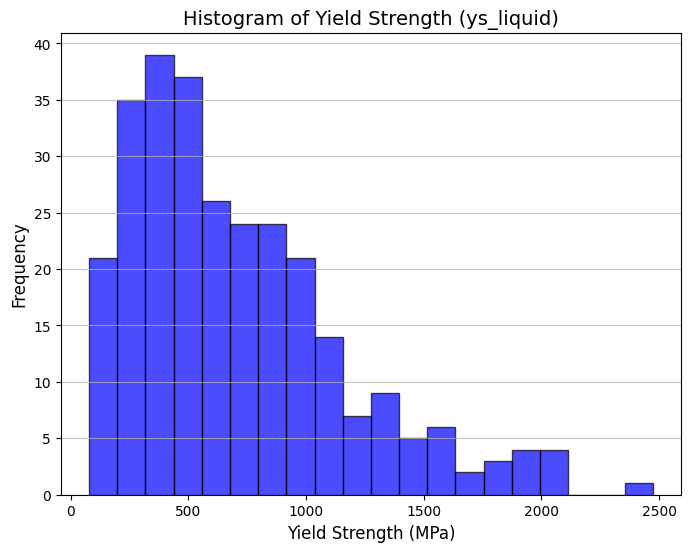

In [61]:
import matplotlib.pyplot as plt

# Plot the histogram for yield strength
plt.figure(figsize=(8, 6))
plt.hist(ys_liquid_cleaned['ys'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Yield Strength (ys_liquid)', fontsize=14)
plt.xlabel('Yield Strength (MPa)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

### Classify phase to SS, SS+IM, IM

In [ ]:
# FCC, BCC, HCP, Laves, B2, L12, AM, IM, SS, Other

def classify(row):
    # due to the lack of AM in dataset, we include it to unknown
    phases = row.phase_cleaned_lm
    if not phases or 'Other' in phases or 'AM' in phases:
        return 'unknown'

    is_ss = False
    is_im = False
    for phase in phases:
        if phase in ['FCC', 'BCC', 'HCP', 'SS']:
            is_ss = True
        if phase in ['Laves', 'B2', 'L12', 'IM']:
            is_im = True
    if is_ss and is_im:
        return 'ss+im'
    if is_ss:
        return 'ss'
    if is_im:
        return 'im'

df['classification'] = df.apply(classify, axis=1)

In [32]:
df.classification.value_counts()

classification
ss         2962
unknown    1424
ss+im      1392
im          137
Name: count, dtype: int64

In [35]:
df_filter = df[df.classification.isin(['ss', 'im', 'ss+im']) & df.composition_type.str.contains('atomic')]

g_l = []
for k, group in df_filter.groupby('composition_cleaned'):
    if group['classification'].nunique() == 1:
        g_l.append(group.iloc[0])

df_phase = pd.DataFrame(g_l)
df_phase

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,phase_cleaned,phase_cleaned_lm,classification,composition_cleaned
177,Pd3Ag1Sn1Pt3Bi1,atomic,[fcc],NaN,NaN,1.39,"[wet chemical synthesis: temperature: 160 °C, ...",tensile,25 °C,10.1002/anie.202304510,[FCC],[FCC],ss,Ag0.111 Bi0.111 Pd0.333 Pt0.333 Sn0.111
686,(Ti8Zr6Nb4V5Cr4)99.9Al0.1,atomic,"[BCC, C14 Laves]",1780.9,1850.8,15.83,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]","[BCC, Laves]",ss+im,Al0.001 Cr0.148 Nb0.148 Ti0.296 V0.185 Zr0.222
687,(Ti8Zr6Nb4V5Cr4)99.8Al0.2,atomic,"[BCC, C14 Laves]",1803.1,1930.9,15.68,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]","[BCC, Laves]",ss+im,Al0.002 Cr0.148 Nb0.148 Ti0.296 V0.185 Zr0.222
688,(Ti8Zr6Nb4V5Cr4)99.7Al0.3,atomic,"[BCC, C14 Laves]",1921.2,1996.9,16.82,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]","[BCC, Laves]",ss+im,Al0.003 Cr0.148 Nb0.148 Ti0.295 V0.185 Zr0.222
689,(Ti8Zr6Nb4V5Cr4)99.6Al0.4,atomic,"[BCC, C14 Laves]",1812.2,1983.7,16.98,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]","[BCC, Laves]",ss+im,Al0.004 Cr0.148 Nb0.148 Ti0.295 V0.184 Zr0.221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,NbTaW,atomic,[BCC],1298.0,1460.0,14.50,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1016/j.jallcom.2021.159740,[BCC],[BCC],ss,Nb0.333 Ta0.333 W0.333
608,NbTiZr,atomic,[BCC],NaN,NaN,NaN,None,tensile,25 °C,10.1007/s40195-021-01252-y,[BCC],[BCC],ss,Nb0.333 Ti0.333 Zr0.333
2778,Ti33.4-V33.3-Nb33.3,atomic,[BCC],632.0,840.0,14.00,[arc melting],tensile,25 °C,10.1016/j.jmrt.2023.09.289,[BCC],[BCC],ss,Nb0.333 Ti0.334 V0.333
4374,Nb1.5TaTiZr0.5,atomic,[BCC + BCC],822.0,852.0,0.33,[as-cast],tensile,25 °C,10.1016/j.msea.2021.141512,[BCC],[BCC],ss,Nb0.375 Ta0.25 Ti0.25 Zr0.125


In [37]:
df_phase.classification.value_counts()

classification
ss       879
ss+im    553
im        54
Name: count, dtype: int64

In [ ]:
# df_phase.to_csv('phase.csv', index=False)

#### Select as-cast compositions

In [30]:
df_filter

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,phase_cleaned,classification,composition_cleaned
0,VCoNi,atomic,[fcc],1000.0,1359.0,38.0,"[induction melting: atmosphere: Ar, homogenize...",tensile,25 °C,10.1002/adma.201807142,[FCC],ss,Co0.333 Ni0.333 V0.333
1,CrCoNi,atomic,[fcc],460.0,NaN,NaN,None,tensile,25 °C,10.1002/adma.201807142,[FCC],ss,Co0.333 Cr0.333 Ni0.333
2,CoCuFeMnNi,atomic,[FCC],259.4,580.3,28.3,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,[FCC],ss,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2
3,CoCuFeMnNi,atomic,"[FCC, Cu-rich FCC]",255.9,576.4,29.0,"[arc melting: atmosphere: Ar, remelting times:...",tensile,25 °C,10.1002/adem.202200523,"[FCC, FCC]",ss,Co0.2 Cu0.2 Fe0.2 Mn0.2 Ni0.2
7,Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04,atomic,"[FCC, γ' precipitates]",1100.0,1700.0,10.0,"[arc melting: atmosphere: Ar, annealed: temper...",tensile,25 °C,10.1016/j.actamat.2020.08.043,"[FCC, γ' precipitates]",ss+im,Al0.105 Co0.175 Fe0.423 Ni0.275 Ta0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,(CuMnNi)80Zn20,atomic,[FCC],140.0,NaN,65.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,[FCC],ss,Cu0.267 Mn0.267 Ni0.267 Zn0.2
5911,(CuMnNi)90Al10,atomic,"[FCC, Im]",515.0,NaN,40.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,"[FCC, Im]",ss+im,Al0.1 Cu0.3 Mn0.3 Ni0.3
5912,(CuMnNi)90Sn10,atomic,"[FCC, Im]",630.0,NaN,20.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,"[FCC, Im]",ss+im,Cu0.3 Mn0.3 Ni0.3 Sn0.1
5913,(CuMnNi)95Al5,atomic,[FCC],330.0,NaN,45.0,None,compressive,25 °C,10.1016/j.dib.2018.11.111,[FCC],ss,Al0.05 Cu0.317 Mn0.317 Ni0.317


In [29]:
df_filter.classification.value_counts(dropna=False)

classification
ss       2785
ss+im    1522
im        289
Name: count, dtype: int64

In [21]:
processes = df.processes
liquid_method = re.compile('(induction|arc|levitation) melting', re.I)
def is_melting_method(p):
    if not p:
        return False
    if len(p) > 1:
        return False
    for process in p:
        if liquid_method.search(process):
            return True
    return False
mask = processes.apply(is_melting_method)
mask

0       False
1       False
2       False
3       False
4       False
        ...  
5910    False
5911    False
5912    False
5913    False
5914    False
Name: processes, Length: 5915, dtype: bool

In [22]:
df_liquid_processed = df[mask]
df_liquid_processed

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,phase_cleaned,classification,composition_cleaned
74,V20Nb20Mo20Ta20W20,atomic,[BCC],NaN,88.0,NaN,"[arc melting: atmosphere: vacuum, remelting ti...",tensile,25 °C,10.1002/adem.201800028,[BCC],None,Mo0.2 Nb0.2 Ta0.2 V0.2 W0.2
75,V20Nb20Mo20Ta20W20,atomic,[BCC],NaN,1660.0,7.0,"[arc melting: atmosphere: vacuum, remelting ti...",compressive,25 °C,10.1002/adem.201800028,[BCC],None,Mo0.2 Nb0.2 Ta0.2 V0.2 W0.2
76,CoCrFeNiNb0.45,atomic,"[FCC, Laves]",1632.0,2094.0,17.4,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,"[FCC, Laves]",None,Co0.225 Cr0.225 Fe0.225 Nb0.101 Ni0.225
77,CoCrFeNiNb0.5,atomic,"[FCC, Laves]",2060.0,2200.0,17.0,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,"[FCC, Laves]",None,Co0.222 Cr0.222 Fe0.222 Nb0.111 Ni0.222
78,CoCrFeNiNb0.55,atomic,"[FCC, Laves]",2043.0,2214.0,12.9,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,"[FCC, Laves]",None,Co0.22 Cr0.22 Fe0.22 Nb0.121 Ni0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,CrMo0.5NbTa0.5TiZr,atomic,[Multiphase],1595.0,2046.0,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[Multiphase],None,Cr0.2 Mo0.1 Nb0.2 Ta0.1 Ti0.2 Zr0.2
5732,CrNbTiVZr,atomic,[Multiphase],1298.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[Multiphase],None,Cr0.2 Nb0.2 Ti0.2 V0.2 Zr0.2
5733,CrNbTiZr,atomic,[Multiphase],1260.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[Multiphase],None,Cr0.25 Nb0.25 Ti0.25 Zr0.25
5734,NbTiVZr,atomic,[BCC],1105.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[BCC],None,Nb0.25 Ti0.25 V0.25 Zr0.25


In [ ]:
df_liquid_processed['classification'] = df_liquid_processed.apply(classify, axis=1)

C:\Users\Soike\AppData\Local\Temp\ipykernel_5436\673758988.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_liquid_processed['classification'] = df_liquid_processed.apply(classify, axis=1)


In [24]:
df_liquid_processed

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,phase_cleaned,classification,composition_cleaned
74,V20Nb20Mo20Ta20W20,atomic,[BCC],NaN,88.0,NaN,"[arc melting: atmosphere: vacuum, remelting ti...",tensile,25 °C,10.1002/adem.201800028,[BCC],ss,Mo0.2 Nb0.2 Ta0.2 V0.2 W0.2
75,V20Nb20Mo20Ta20W20,atomic,[BCC],NaN,1660.0,7.0,"[arc melting: atmosphere: vacuum, remelting ti...",compressive,25 °C,10.1002/adem.201800028,[BCC],ss,Mo0.2 Nb0.2 Ta0.2 V0.2 W0.2
76,CoCrFeNiNb0.45,atomic,"[FCC, Laves]",1632.0,2094.0,17.4,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,"[FCC, Laves]",ss+im,Co0.225 Cr0.225 Fe0.225 Nb0.101 Ni0.225
77,CoCrFeNiNb0.5,atomic,"[FCC, Laves]",2060.0,2200.0,17.0,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,"[FCC, Laves]",ss+im,Co0.222 Cr0.222 Fe0.222 Nb0.111 Ni0.222
78,CoCrFeNiNb0.55,atomic,"[FCC, Laves]",2043.0,2214.0,12.9,"[arc melting: atmosphere: Ar, remelting times:...",compressive,25 °C,10.1002/adem.201700908,"[FCC, Laves]",ss+im,Co0.22 Cr0.22 Fe0.22 Nb0.121 Ni0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,CrMo0.5NbTa0.5TiZr,atomic,[Multiphase],1595.0,2046.0,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[Multiphase],im,Cr0.2 Mo0.1 Nb0.2 Ta0.1 Ti0.2 Zr0.2
5732,CrNbTiVZr,atomic,[Multiphase],1298.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[Multiphase],im,Cr0.2 Nb0.2 Ti0.2 V0.2 Zr0.2
5733,CrNbTiZr,atomic,[Multiphase],1260.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[Multiphase],im,Cr0.25 Nb0.25 Ti0.25 Zr0.25
5734,NbTiVZr,atomic,[BCC],1105.0,NaN,NaN,[vacuum arc melting],tensile,25 °C,10.1016/j.matchemphys.2024.130091,[BCC],ss,Nb0.25 Ti0.25 V0.25 Zr0.25


In [26]:
# data cleaning
# we need to remove those conflict ones (same composition but different phase classification)
# df_liquid_processed['composition_cleaned'] = df_liquid_processed.composition.apply(parse_material)
df_liquid_processed_f = df_liquid_processed[df_liquid_processed.classification.isin(['ss', 'im', 'ss+im']) & df_liquid_processed.composition_type.str.contains('atomic')]

g_l = []
for k, group in df_liquid_processed_f.groupby('composition_cleaned'):
    if group['classification'].nunique() == 1:
        g_l.append(group.iloc[0])

df_conc = pd.DataFrame(g_l)
df_conc

,composition,composition_type,phase,ys,uts,strain,processes,test_type,test_temperature,doi,phase_cleaned,classification,composition_cleaned
686,(Ti8Zr6Nb4V5Cr4)99.9Al0.1,atomic,"[BCC, C14 Laves]",1780.9,1850.8,15.83,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]",ss+im,Al0.001 Cr0.148 Nb0.148 Ti0.296 V0.185 Zr0.222
687,(Ti8Zr6Nb4V5Cr4)99.8Al0.2,atomic,"[BCC, C14 Laves]",1803.1,1930.9,15.68,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]",ss+im,Al0.002 Cr0.148 Nb0.148 Ti0.296 V0.185 Zr0.222
688,(Ti8Zr6Nb4V5Cr4)99.7Al0.3,atomic,"[BCC, C14 Laves]",1921.2,1996.9,16.82,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]",ss+im,Al0.003 Cr0.148 Nb0.148 Ti0.295 V0.185 Zr0.222
689,(Ti8Zr6Nb4V5Cr4)99.6Al0.4,atomic,"[BCC, C14 Laves]",1812.2,1983.7,16.98,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s42243-024-01280-9,"[BCC, Laves]",ss+im,Al0.004 Cr0.148 Nb0.148 Ti0.295 V0.184 Zr0.221
236,Fe2CoNi(AlSi)0.1,atomic,"[FCC, PC]",740.6,NaN,NaN,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1007/s00339-021-04988-7,"[FCC, PC]",ss+im,Al0.012 Co0.244 Fe0.488 Ni0.244 Si0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,Ti33-V33-Nb33-Zr1,atomic,[BCC],NaN,NaN,NaN,[arc melting],tensile,25 °C,10.1016/j.jmrt.2023.09.289,[BCC],ss,Nb0.33 Ti0.33 V0.33 Zr0.01
4331,VNbTa,atomic,[BCC],925.0,1050.0,26.00,"[arc melting: atmosphere: Ar, remelting times: 8]",tensile,25 °C,10.1016/j.msea.2021.141908,[BCC],ss,Nb0.333 Ta0.333 V0.333
2015,NbTaW,atomic,[BCC],1298.0,1460.0,14.50,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1016/j.jallcom.2021.159740,[BCC],ss,Nb0.333 Ta0.333 W0.333
2253,TiNbZrMo0,atomic,[BCC],NaN,NaN,NaN,"[arc melting: atmosphere: Ar, remelting times: 5]",compressive,25 °C,10.1016/j.jallcom.2022.167373,[BCC],ss,Nb0.333 Ti0.333 Zr0.333


In [27]:
df_conc.classification.value_counts()

classification
ss       405
ss+im    341
im        49
Name: count, dtype: int64

In [ ]:
# df_conc.to_csv('liquid_processed_phase_cls_ss_im.csv', index=False)